## BATCH aligner

#### Introduction

In metabolomics and natural product research, it is crucial to ensure that features detected across multiple batches of mass spectrometry (MS) data are accurately aligned and comparable. This notebook provides a workflow for aligning MS features across different batches, focusing on interbatch comparison and annotation of compounds. The method is designed specifically for features that include MS/MS data, which allows for a more precise and reliable alignment process.
Traditionally, a study will comprise a sigle species in different treatments. In such situations, most compounds are common and the difference is expected to rise from differential concentrations. But when dealing with biological collections of different taxons, most compounds may be different across different samples and different batches. When this is the case, how can we align data from different batches and correct for batch effect?

#### Objectives

##### The primary goals of this notebook are:

* Feature Alignment: Align MS features from multiple batches based on retention time (RT) and mass-to-charge ratio (m/z) thresholds.
* MS Similarity Calculation: Filter aligned features by computing the similarity between their MS/MS spectra to ensure they are indeed the same features across batches.
* Visualization: Plot and visualize the aligned features to facilitate further analysis and validation.

#### Methodology

##### The notebook is structured to perform the following key steps:

1. Data Import and Setup: Read MS feature data from .csv files corresponding to different batches and set up the necessary environment for processing.

Data Requirements:

    1. Process each batch using MZMine accordingly.
    2. Export the aligned feature list for applying the exported data to:
        (a) GNPS-FBMN (xxxx_quant.csv + xxxx.mgf)
        (b) MetaboAnalyst (xxxx_MetaboAnalyst.csv)
    3. Name the exported files as follows: xxxx_batch#.mgf, xxxx_batch#.csv, xxxx_batch#_MetaboAnalyst.csv
        xxxx is the "project name" (e.g., "PHerb1"), and # refers to the batch number.


2. Feature Alignment: Use the _align_features_ function to merge features from different batches based on predefined RT and m/z thresholds.
3. MS Similarity Filtering: Apply the _filter_aligned_features_ function to compare MS/MS spectra of aligned features, retaining only those with high similarity.
4. Visualization: Utilize plotting functions to visualize the spectra of aligned features, both for specific scan numbers and for randomly selected features.

#### Notes

* Scope: This method focuses exclusively on features with MS/MS data, as those without MS/MS data are outside the scope of this alignment approach.
* Application: The alignment and visualization techniques provided here are tailored for applications in natural products and metabolomics research, where accurate interbatch comparison is essential.

---
#### Import the necessary libraries for data manipulation, computation, and visualization.


In [1]:
import pandas as pd  # pandas: for handling data in DataFrames
import numpy as np  # numpy: for numerical operations
import matplotlib.pyplot as plt  # matplotlib: for plotting data
from sklearn.metrics.pairwise import cosine_similarity  # sklearn: for cosine similarity computation
from tqdm import tqdm  # tqdm: for progress bars
import random  # random: for random operations
import os  # os: for operating system interfaces
from pyteomics import mgf  # pyteomics: for handling MGF files
import plotly.graph_objects as go  # plotly: for interactive plots
from itertools import cycle  # itertools: for creating iterators

---
#### Define the directory containing the MGF and CSV files and sets the project prefix

In [2]:
# Directory containing .mgf files and related MetaboAnalyst.csv files
directory_path = r'C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches'

# Define the output directory for saving the aligned DataFrame
output_directory = directory_path  # Replace with your desired directory path

# Define the project
project_prefix = "Controles_Lote_"

---
#### Parse the MGF files to extract MS spectra for each batch

This sets up the directory path for the MGF and MetaboAnalyst.csv files and defines a function to parse the MGF files. Follow these steps:

The parse_mgf_files function manually reads each MGF file, extracts the spectra data, and stores it in a dictionary. The purpose is to load and verify the spectral data from the MGF files for further analysis.

In [3]:
# Function to parse MGF files manually
def parse_mgf_files(directory_path):
    mgf_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.mgf')]
    spectra = {}
    for mgf_file in mgf_files:
        print(f"Processing MGF file: {mgf_file}")
        batch_name = os.path.basename(mgf_file).replace('.mgf', '')
        spectra[batch_name] = []
        with open(mgf_file, 'r') as file:
            current_spectrum = None
            for line in file:
                line = line.strip()
                if line == "BEGIN IONS":
                    current_spectrum = {'params': {}, 'm/z array': [], 'intensity array': []}
                elif line == "END IONS":
                    if current_spectrum:
                        spectra[batch_name].append(current_spectrum)
                elif '=' in line:
                    key, value = line.split('=', 1)
                    current_spectrum['params'][key] = value
                else:
                    parts = line.split()
                    if len(parts) == 2:
                        mz, intensity = map(float, parts)
                        current_spectrum['m/z array'].append(mz)
                        current_spectrum['intensity array'].append(intensity)
    return spectra

# Parse .mgf files to get spectra
spectra = parse_mgf_files(directory_path)

# Verify that the spectra have been loaded correctly
for batch_name, batch_spectra in spectra.items():
    print(f"Batch: {batch_name}, Number of spectra: {len(batch_spectra)}")

Processing MGF file: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_1_2024_10_02.mgf
Processing MGF file: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_2_2024_10_02.mgf
Processing MGF file: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_3_2024_10_08.mgf
Processing MGF file: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_4_2024_10_08.mgf
Batch: Controles_Lote_1_2024_10_02, Number of spectra: 49
Batch: Controles_Lote_2_2024_10_02, Number of spectra: 51
Batch: Controles_Lote_3_2024_10_08, Number of spectra: 29
Batch: Controles_Lote_4_2024_10_08, Number of spectra: 23


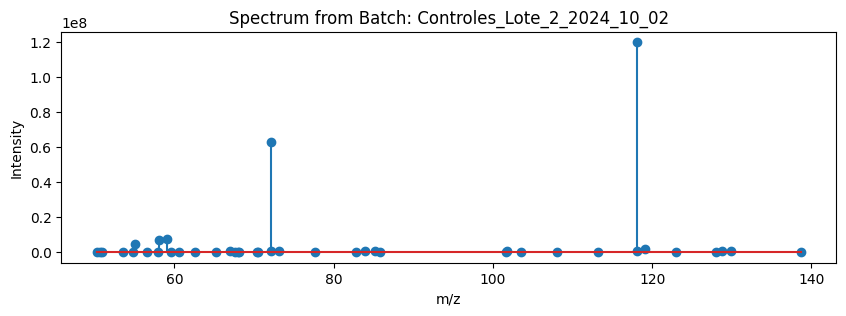

In [4]:
# Plot the a spectrum of a batch
batch_name = list(spectra.keys())[1]  # Get the first batch name
if spectra[batch_name]:
    first_spectrum = spectra[batch_name][3]  # Get the first spectrum of the batch
    plt.figure(figsize=(10, 3))
    plt.stem(first_spectrum['m/z array'], first_spectrum['intensity array'])
    plt.title(f"Spectrum from Batch: {batch_name}")
    plt.xlabel("m/z")
    plt.ylabel("Intensity")
    plt.show()


In [5]:
import os
import pandas as pd

def extract_values_and_create_dfs(directory_path):
    """
    Reads all _MetaboAnalyst.csv files from a directory and creates DataFrames for each file, extracting 
    scan_number, mz_value, and rt_value.
    Parameters:
    - directory_path: str, path to the directory containing the _MetaboAnalyst.csv files.
    Returns:
    - dfs: dict, keys are dynamic names for DataFrames, values are DataFrames.
    - first_rows: dict, keys are filenames, values are the first row of each DataFrame.
    """
    dfs = {}
    first_rows = {}

    # Get all files in the directory ending with '_MetaboAnalyst.csv'
    file_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('_MetaboAnalyst.csv')]

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        
        filename = os.path.basename(file_path).replace('_MetaboAnalyst.csv', '')
        
        # Safely extract 'scan_number', 'mz_value', and 'rt_value' with regex
        df[['scan_number', 'mz_value', 'rt_value']] = df.iloc[:, 0].str.extract(r'(\d+)/([\d.]+)mz/([\d.]+)min', expand=True)
        
        # Handle any rows where extraction failed (NaNs after extraction)
        df = df.fillna({'scan_number': 0, 'mz_value': 0.0, 'rt_value': 0.0})
        
        # Convert to correct data types
        df['scan_number'] = df['scan_number'].astype(int)
        df['mz_value'] = df['mz_value'].astype(float)
        df['rt_value'] = df['rt_value'].astype(float)
        
        # Add the batch name and feature_batch
        df['batch'] = filename
        df['feature_batch'] = df['scan_number'].astype(str) + "_" + filename
        
        # Reorder columns: keep scan_number, mz_value, rt_value, batch, and feature_batch first
        cols = ['scan_number', 'mz_value', 'rt_value', 'batch', 'feature_batch'] + [col for col in df.columns if col not in ['scan_number', 'mz_value', 'rt_value', 'batch', 'feature_batch']]
        df = df[cols]
        
        # Store the first row for later use
        first_rows[filename] = df.iloc[0]
        
        # Exclude the first row (because it's stored separately)
        df = df.iloc[1:]
        
        # Store the DataFrame with a dynamic name
        dfs[f'df_{filename}'] = df

    return dfs, first_rows

# Extract data and create DataFrames
dfs, first_rows = extract_values_and_create_dfs(directory_path)

# Example of how to access DataFrames:
#dfs

---
#### Read the MetaboAnalyst CSV files, creates DataFrames for each batch, and extracts relevant information for alignment

This step reads the MetaboAnalyst.csv files, extracts the relevant data, and creates a DataFrame for each file.

    1. Process each file to extract scan numbers, mz values, and rt values.
    2. Handle missing data by replacing NaN values with 0.
    3. Convert data types appropriately for analysis.
    4. Add batch information to each DataFrame.

* The function extract_values_and_create_dfs reads _MetaboAnalyst.csv files from the specified directory, extracting key information such as scan_number, mz_value, rt_value, and the batch identifier.
* The first row of each batch, which contains classification information, is excluded from the alignment process but saved for future use.

The processed DataFrames are stored in a dictionary for further analysis.

---
### Aligns features across batches based on retention time (rt_value) and m/z (mz_value) thresholds, ensuring alignment information is recorded for future analysis

* The align_features function aligns features across batches by comparing mz_value and rt_value with specified thresholds (mz_threshold and rt_threshold).
* Features are matched and grouped together if their m/z and RT values fall within the defined thresholds.
* Intensities of matched features are combined, and an aligned_features column is created to indicate which features from different batches have been aligned.


In [8]:
def align_features(dfs, mz_threshold=0.01, rt_threshold=0.2):
    """
    Aligns features across batches based on mz_value and rt_value thresholds.
    Features from the same batch are not aligned.
    
    Parameters:
    - dfs: dict of DataFrames, where each DataFrame corresponds to a batch.
    - mz_threshold: float, threshold for m/z value difference.
    - rt_threshold: float, threshold for retention time difference.
    
    Returns:
    - aligned_df: DataFrame, containing aligned features across batches.
    """
    aligned_features = []
    seen_features = set()

    # Extract features grouped by batch
    features_by_batch = {
        batch_name: [
            {
                'batch_name': batch_name,
                'scan_number': row['scan_number'],
                'mz_value': row['mz_value'],
                'rt_value': row['rt_value'],
                'intensity': row.iloc[4:].to_dict() if len(df.columns) > 4 else {},  # No normalization
                'feature_batch': row['feature_batch']
            }
            for _, row in df.iterrows()
        ]
        for batch_name, df in dfs.items()
    }

    # Iterate over batches to compare features across different batches
    for batch_name, features in features_by_batch.items():
        for feature in features:
            feature_key = (feature['scan_number'], feature['mz_value'], feature['rt_value'], feature['feature_batch'])
            if feature_key in seen_features:
                continue

            aligned = {
                'scan_number': feature['scan_number'],
                'mz_value': feature['mz_value'],
                'rt_value': feature['rt_value'],
                'feature_batch': feature['feature_batch'],
                'intensities': {feature['batch_name']: feature['intensity']},
                'aligned_features': [feature['feature_batch']]
            }

            # Compare only with features from other batches
            for other_batch_name, other_features in features_by_batch.items():
                if batch_name == other_batch_name:  # Skip features from the same batch
                    continue

                for other_feature in other_features:
                    mz_diff = abs(feature['mz_value'] - other_feature['mz_value'])
                    rt_diff = abs(feature['rt_value'] - other_feature['rt_value'])

                    if mz_diff <= mz_threshold and rt_diff <= rt_threshold:
                        aligned['intensities'][other_feature['batch_name']] = other_feature['intensity']
                        aligned['aligned_features'].append(other_feature['feature_batch'])
                        seen_features.add((other_feature['scan_number'], other_feature['mz_value'], other_feature['rt_value'], other_feature['feature_batch']))

            # Save aligned feature
            aligned_features.append(aligned)
            seen_features.add(feature_key)

    # Flatten the intensity dictionaries and aligned feature info
    flattened_features = []
    for feature in aligned_features:
        flattened_feature = {
            'scan_number': feature['scan_number'],
            'mz_value': feature['mz_value'],
            'rt_value': feature['rt_value'],
            'feature_batch': feature['feature_batch'],
            'aligned_features': '; '.join(feature['aligned_features'])
        }
        for batch, intensity_dict in feature['intensities'].items():
            for sample, intensity in intensity_dict.items():
                flattened_feature[f'{batch}_{sample}'] = intensity
        flattened_features.append(flattened_feature)

    # Create a DataFrame from the flattened features
    aligned_df = pd.DataFrame(flattened_features)

    return aligned_df


In [9]:
# Align the features across batches
aligned_rt_mz_df = align_features(dfs, mz_threshold=0.01, rt_threshold=0.2)

# Ensure the output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the output file path for the aligned DataFrame
output_file_path = os.path.join(output_directory, 'aligned_rt_mz_df.csv')

# Save the aligned DataFrame to the specified CSV file
aligned_rt_mz_df.to_csv(output_file_path, index=False)

# Display the aligned DataFrame
pd.set_option("display.max_colwidth", None)  # Ensure long column contents are displayed
pd.set_option("display.max_columns", None)  # Ensure all columns are displayed
display(aligned_rt_mz_df.head())  # Print the first few rows for quick inspection


,scan_number,mz_value,rt_value,feature_batch,aligned_features,df_Controles_Lote_1_2024_10_02_feature_batch,df_Controles_Lote_1_2024_10_02_Filename,df_Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024224356.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024172649.mzML,df_Controles_Lote_1_2024_10_02_BLANK.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024174844.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024230550.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231025023336.mzML,df_Controles_Lote_1_2024_10_02_CQExt.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024150135.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024173747.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024225453.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024202144.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231025022239.mzML,df_Controles_Lote_2_2024_10_02_feature_batch,df_Controles_Lote_2_2024_10_02_Filename,df_Controles_Lote_2_2024_10_02_BLANK_20231027104459.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027133206.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027160510.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025060121.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025090714.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025024434.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027161607.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025030633.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027134303.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025062315.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027105901.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025084520.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025025536.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231027110958.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025085618.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025061218.mzML,df_Controles_Lote_3_2024_10_08_feature_batch,df_Controles_Lote_3_2024_10_08_Filename,df_Controles_Lote_3_2024_10_08_BLANK_20231027212212.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231027184908.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231028021108.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231027190006.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231027213309.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231028022205.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027162704.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231028023305.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027214406.mzML,df_Controles_Lote_4_2024_10_08_feature_batch,df_Controles_Lote_4_2024_10_08_Filename,df_Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML
0,1,181.0721,0.03,1_Controles_Lote_1_2024_10_02,1_Controles_Lote_1_2024_10_02,1_Controles_Lote_1_2024_10_02,1/181.0721mz/0.03min,NaN,NaN,NaN,NaN,NaN,NaN,8698.8095703125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,196.0918,0.03,2_Controles_Lote_1_2024_10_02,2_Controles_Lote_1_2024_10_02,2_Controles_Lote_1_2024_10_02,2/196.0918mz/0.03min,NaN,NaN,NaN,NaN,NaN,NaN,15184.4306640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,351.0694,0.22,3_Controles_Lote

In [8]:
print(f"{aligned_rt_mz_df.shape} features aligned to RT and m/z")

(70, 40) features aligned to RT and m/z


In [19]:
aligned_rt_mz_df.iloc[[32]]

,scan_number,mz_value,rt_value,feature_batch,aligned_features,df_Controles_Lote_1_2024_10_02_feature_batch,df_Controles_Lote_1_2024_10_02_Filename,df_Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024224356.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024172649.mzML,df_Controles_Lote_1_2024_10_02_BLANK.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024174844.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024230550.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231025023336.mzML,df_Controles_Lote_1_2024_10_02_CQExt.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024150135.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024173747.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024225453.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024202144.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231025022239.mzML,df_Controles_Lote_2_2024_10_02_feature_batch,df_Controles_Lote_2_2024_10_02_Filename,df_Controles_Lote_2_2024_10_02_BLANK_20231027104459.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027133206.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027160510.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025060121.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025090714.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025024434.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027161607.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025030633.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027134303.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025062315.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027105901.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025084520.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025025536.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231027110958.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025085618.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025061218.mzML,df_Controles_Lote_3_2024_10_08_feature_batch,df_Controles_Lote_3_2024_10_08_Filename,df_Controles_Lote_3_2024_10_08_BLANK_20231027212212.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231027184908.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231028021108.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231027190006.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231027213309.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231028022205.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027162704.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231028023305.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027214406.mzML,df_Controles_Lote_4_2024_10_08_feature_batch,df_Controles_Lote_4_2024_10_08_Filename,df_Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML
32,33,195.0881,1.5,33_Controles_Lote_1_2024_10_02,33_Controles_Lote_1_2024_10_02; 35_Controles_Lote_2_2024_10_02; 24_Controles_Lote_3_2024_10_08; 18_Controles_Lote_4_2024_10_08,33_Controles_Lote_1_2024_10_02,33/195.0881mz/1.50min,NaN,NaN,NaN,NaN,NaN,NaN,2.30047312E8,3.14827456E8,2.45146272E8,5.32280448E8,3.554456E8,4.62397088E8,4.59906688E8,4.7336432E8,5.32874336E8,5.35728192E8,35_Controles_Lote_2_2024_10_02,35/195.0881mz/1.49min,NaN,NaN,NaN,NaN,NaN,NaN,2.41028128E8,2.24324912E8,2.55555952E8,2.91894848E8,2.49920144E8,2.77717664E8,5.30145824E8,4.64361888E8,5.06563904E8,5.58741632E8,24_Controles_Lote_3_2024_10_08,24/195.0885mz/1.47min,NaN,NaN,NaN,1.692284E8,1.86287952E8,2.25137776E8,3.47967488E8,3.34674848E8,3.0240448E8,18_Controles_Lote_4_2024_10_08,18/195

---
### Note:

* This method is specifically designed for interbatch comparison and annotation of compounds in Natural Products and Metabolomics.
* Only features with MS/MS data are included in the alignment, as features without MS/MS data fall outside the scope of this method.
---

#### Calculating Cosine Similarity and Filtering ALigned 

* The calculate_cosine_similarity function computes the cosine similarity between two spectra.
* Filter Aligned Features:
    * The filter_aligned_features function filters aligned features based on cosine similarity.
    * It iterates over the aligned_rt_mz_df, checks the cosine similarity for each pair of aligned spectra, and retains only those with similarity above the threshold.
 

##### Features without MS/MS spectra:

* If a feature does not have an MS/MS spectrum, the spectrum1 or spectrum2 will be None, and the cosine similarity calculation will be skipped for that feature pair.
    * Such features are excluded from the filtered list of aligned features because their similarity cannot be calculated.
 

##### Features that do not align
* (i.e., features that do not find a match within the specified mz_value and rt_value thresholds) are not retained in the final filtered list.
* The alignment process only retains features that match across batches based on those thresholds and, optionally, meet the cosine similarity criteria for their MS/MS spectra.

#### NÂO SEI DIZER SE É A MELHOR OPÇÂO.

---
#### Filters aligned features based on cosine similarity of MS spectra, using the filter_aligned_features() function to retain only well-aligned features

In [21]:
import numpy as np
import pandas as pd

def normalize_spectrum(spectrum):
    """
    Normalizes the intensities in a spectrum so that their sum equals 1.
    Handles cases where spectra might be empty.
    """
    if not spectrum['intensity array']:
        return spectrum  # Return as is if there are no intensity values
    
    intensities = np.array(spectrum['intensity array'], dtype=float)
    total_intensity = np.sum(intensities)
    if total_intensity > 0:
        spectrum['intensity array'] = intensities / total_intensity
    return spectrum

def find_full_batch_name(batch, spectra_keys):
    """
    Finds the full batch name dynamically from the spectra dictionary.
    Returns None if no match is found.
    """
    matches = [key for key in spectra_keys if batch in key]
    return matches[0] if matches else None

def calculate_cosine_similarity(spectrum1, spectrum2, mz_tolerance=0.01):
    """
    Calculate cosine similarity between two normalized spectra.
    Includes filtering based on m/z tolerance.
    """
    if not spectrum1['m/z array'] or not spectrum2['m/z array']:
        return 0  # Avoid calculations if either spectrum is empty
    
    mz1, intensity1 = np.array(spectrum1['m/z array']), np.array(spectrum1['intensity array'])
    mz2, intensity2 = np.array(spectrum2['m/z array']), np.array(spectrum2['intensity array'])

    matched_intensities1, matched_intensities2 = [], []
    for i, mz in enumerate(mz1):
        diff = np.abs(mz2 - mz)
        if np.any(diff <= mz_tolerance):
            idx = np.argmin(diff)
            matched_intensities1.append(intensity1[i])
            matched_intensities2.append(intensity2[idx])

    if len(matched_intensities1) == 0:
        return 0  # No matching peaks

    # Normalize matched intensities
    matched_intensities1 = np.array(matched_intensities1) / np.sum(matched_intensities1)
    matched_intensities2 = np.array(matched_intensities2) / np.sum(matched_intensities2)

    # Calculate cosine similarity
    return np.dot(matched_intensities1, matched_intensities2) / (
        np.linalg.norm(matched_intensities1) * np.linalg.norm(matched_intensities2)
    )

def filter_aligned_features(aligned_df, spectra, project_prefix, cosine_threshold=0.99, mz_tolerance=0.001):
    """
    Filters aligned features based on MS spectra similarity with improved peak matching.
    Ensures valid feature_batch parsing and prevents misalignment of intensity values.
    """
    filtered_features = []
    spectra_keys = spectra.keys()
    retained_columns = aligned_df.columns  # Preserve all columns including intensities

    for _, row in aligned_df.iterrows():
        aligned_batches = row['aligned_features'].split('; ')
        if len(aligned_batches) < 2:
            continue  # Skip if no alignments

        similarities = []
        for i in range(len(aligned_batches) - 1):
            try:
                scan1, batch1 = aligned_batches[i].rsplit('_', 1)
                scan2, batch2 = aligned_batches[i + 1].rsplit('_', 1)
            except ValueError:
                continue  # Skip if unexpected format

            # Find full batch names
            batch1_full = find_full_batch_name(batch1, spectra_keys)
            batch2_full = find_full_batch_name(batch2, spectra_keys)

            if batch1_full is None or batch2_full is None:
                continue

            # Fetch and normalize spectra
            spectrum1 = next((normalize_spectrum(s) for s in spectra[batch1_full] if s['params'].get('FEATURE_ID') == scan1), None)
            spectrum2 = next((normalize_spectrum(s) for s in spectra[batch2_full] if s['params'].get('FEATURE_ID') == scan2), None)

            if spectrum1 and spectrum2:
                cos_sim = calculate_cosine_similarity(spectrum1, spectrum2, mz_tolerance)
                similarities.append(cos_sim)

        if all(sim >= cosine_threshold for sim in similarities):
            filtered_features.append(row.to_dict())  # Preserve all original columns

    return pd.DataFrame(filtered_features, columns=retained_columns)  # Ensure all columns remain


In [22]:
# Apply the updated filtering function with enhanced cosine similarity and normalization
MSfiltered_aligned_features_df = filter_aligned_features(
    aligned_rt_mz_df,
    spectra,  # Dictionary of spectra
    project_prefix,  # Prefix for project batches
    cosine_threshold=1,  # Adjusted cosine similarity threshold
    mz_tolerance=0.001  # Tolerance for m/z matching
)

# Display the filtered DataFrame
pd.set_option("max_colwidth", None)  # Display full content of any long columns
pd.set_option("display.max_columns", None)  # Display all columns
#display(MSfiltered_aligned_features_df)  # Display the first few rows for inspection

# Save the filtered DataFrame to the specified subdirectory
output_directory = os.path.join(directory_path, 'alignment_info_df')  # Subdirectory for filtered alignment info
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

output_file_path = os.path.join(output_directory, 'MSfiltered_aligned_features_df.csv')
MSfiltered_aligned_features_df.to_csv(output_file_path, index=False)

print(f"Filtered features saved to: {output_file_path}")

Filtered features saved to: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\alignment_info_df\MSfiltered_aligned_features_df.csv


In [24]:
MSfiltered_aligned_features_df.iloc[[29]]

,scan_number,mz_value,rt_value,feature_batch,aligned_features,df_Controles_Lote_1_2024_10_02_feature_batch,df_Controles_Lote_1_2024_10_02_Filename,df_Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024224356.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024172649.mzML,df_Controles_Lote_1_2024_10_02_BLANK.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024174844.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024230550.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231025023336.mzML,df_Controles_Lote_1_2024_10_02_CQExt.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024150135.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024173747.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024225453.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024202144.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231025022239.mzML,df_Controles_Lote_2_2024_10_02_feature_batch,df_Controles_Lote_2_2024_10_02_Filename,df_Controles_Lote_2_2024_10_02_BLANK_20231027104459.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027133206.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027160510.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025060121.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025090714.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025024434.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027161607.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025030633.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027134303.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025062315.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027105901.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025084520.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025025536.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231027110958.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025085618.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025061218.mzML,df_Controles_Lote_3_2024_10_08_feature_batch,df_Controles_Lote_3_2024_10_08_Filename,df_Controles_Lote_3_2024_10_08_BLANK_20231027212212.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231027184908.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231028021108.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231027190006.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231027213309.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231028022205.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027162704.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231028023305.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027214406.mzML,df_Controles_Lote_4_2024_10_08_feature_batch,df_Controles_Lote_4_2024_10_08_Filename,df_Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML
29,33,195.0881,1.5,33_Controles_Lote_1_2024_10_02,33_Controles_Lote_1_2024_10_02; 35_Controles_Lote_2_2024_10_02; 24_Controles_Lote_3_2024_10_08; 18_Controles_Lote_4_2024_10_08,33_Controles_Lote_1_2024_10_02,33/195.0881mz/1.50min,NaN,NaN,NaN,NaN,NaN,NaN,2.30047312E8,3.14827456E8,2.45146272E8,5.32280448E8,3.554456E8,4.62397088E8,4.59906688E8,4.7336432E8,5.32874336E8,5.35728192E8,35_Controles_Lote_2_2024_10_02,35/195.0881mz/1.49min,NaN,NaN,NaN,NaN,NaN,NaN,2.41028128E8,2.24324912E8,2.55555952E8,2.91894848E8,2.49920144E8,2.77717664E8,5.30145824E8,4.64361888E8,5.06563904E8,5.58741632E8,24_Controles_Lote_3_2024_10_08,24/195.0885mz/1.47min,NaN,NaN,NaN,1.692284E8,1.86287952E8,2.25137776E8,3.47967488E8,3.34674848E8,3.0240448E8,18_Controles_Lote_4_2024_10_08,18/195

In [25]:
aligned_rt_mz_df.iloc[[32]]

,scan_number,mz_value,rt_value,feature_batch,aligned_features,df_Controles_Lote_1_2024_10_02_feature_batch,df_Controles_Lote_1_2024_10_02_Filename,df_Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024224356.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024172649.mzML,df_Controles_Lote_1_2024_10_02_BLANK.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024174844.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024230550.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231025023336.mzML,df_Controles_Lote_1_2024_10_02_CQExt.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024150135.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024173747.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024225453.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024202144.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231025022239.mzML,df_Controles_Lote_2_2024_10_02_feature_batch,df_Controles_Lote_2_2024_10_02_Filename,df_Controles_Lote_2_2024_10_02_BLANK_20231027104459.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027133206.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027160510.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025060121.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025090714.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025024434.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027161607.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025030633.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027134303.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025062315.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027105901.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025084520.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025025536.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231027110958.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025085618.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025061218.mzML,df_Controles_Lote_3_2024_10_08_feature_batch,df_Controles_Lote_3_2024_10_08_Filename,df_Controles_Lote_3_2024_10_08_BLANK_20231027212212.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231027184908.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231028021108.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231027190006.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231027213309.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231028022205.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027162704.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231028023305.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027214406.mzML,df_Controles_Lote_4_2024_10_08_feature_batch,df_Controles_Lote_4_2024_10_08_Filename,df_Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML
32,33,195.0881,1.5,33_Controles_Lote_1_2024_10_02,33_Controles_Lote_1_2024_10_02; 35_Controles_Lote_2_2024_10_02; 24_Controles_Lote_3_2024_10_08; 18_Controles_Lote_4_2024_10_08,33_Controles_Lote_1_2024_10_02,33/195.0881mz/1.50min,NaN,NaN,NaN,NaN,NaN,NaN,2.30047312E8,3.14827456E8,2.45146272E8,5.32280448E8,3.554456E8,4.62397088E8,4.59906688E8,4.7336432E8,5.32874336E8,5.35728192E8,35_Controles_Lote_2_2024_10_02,35/195.0881mz/1.49min,NaN,NaN,NaN,NaN,NaN,NaN,2.41028128E8,2.24324912E8,2.55555952E8,2.91894848E8,2.49920144E8,2.77717664E8,5.30145824E8,4.64361888E8,5.06563904E8,5.58741632E8,24_Controles_Lote_3_2024_10_08,24/195.0885mz/1.47min,NaN,NaN,NaN,1.692284E8,1.86287952E8,2.25137776E8,3.47967488E8,3.34674848E8,3.0240448E8,18_Controles_Lote_4_2024_10_08,18/195

In [ ]:
print(f"{aligned_rt_mz_df.shape} features aligned to RT and m/z")
print(f"{MSfiltered_aligned_features_df.shape} filtered for MS spectra")

In [ ]:
MSfiltered_aligned_features_df

---
#### Visualize the aligned MS spectra using Plotly, allowing for stacked spectrum comparison

In [26]:
def plot_ms_spectra_direct_read(mgf_file, feature_ids, mz_min=None, mz_max=None):
    found_spectra = False  # Flag to check if any matching spectra are found
    mz_values = []
    intensity_values = []
    current_feature_id = None

    with open(mgf_file, 'r') as file:
        for line in file:
            line = line.strip()           
            # Start a new spectrum
            if line == "BEGIN IONS":
                mz_values = []
                intensity_values = []
                current_feature_id = None
            # Check for FEATURE_ID
            elif line.startswith("FEATURE_ID="):
                current_feature_id = line.split("=")[1].strip()
            # Parse m/z and intensity pairs
            elif line and not line.startswith("END IONS") and not line.startswith("FEATURE_ID"):
                try:
                    mz, intensity = line.split()
                    mz_values.append(float(mz))
                    intensity_values.append(float(intensity))
                except ValueError:
                    continue
            # End of a spectrum, check if it matches the desired FEATURE_ID
            elif line == "END IONS" and current_feature_id in feature_ids:
                found_spectra = True
                plt.figure(figsize=(10, 3))
                plt.stem(mz_values, intensity_values, markerfmt=" ", basefmt=" ")
                plt.xlabel('m/z')
                plt.ylabel('Intensity')
                plt.title(f'Spectrum for FEATURE_ID: {current_feature_id}')
                
                # Set spectral window if specified
                if mz_min is not None and mz_max is not None:
                    plt.xlim(mz_min, mz_max)
                plt.show()

    if not found_spectra:
        print("No matching FEATURE_IDs found in the file.")

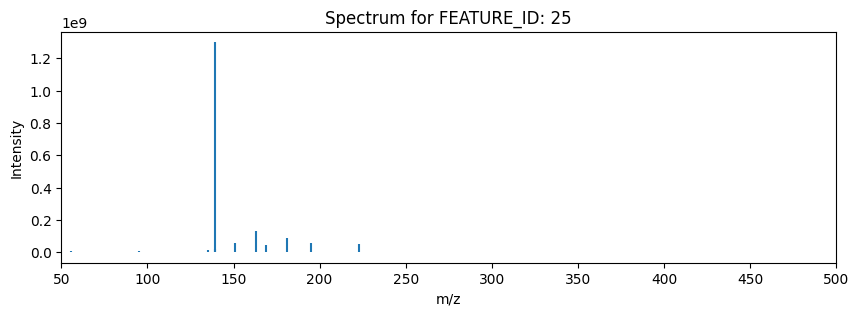

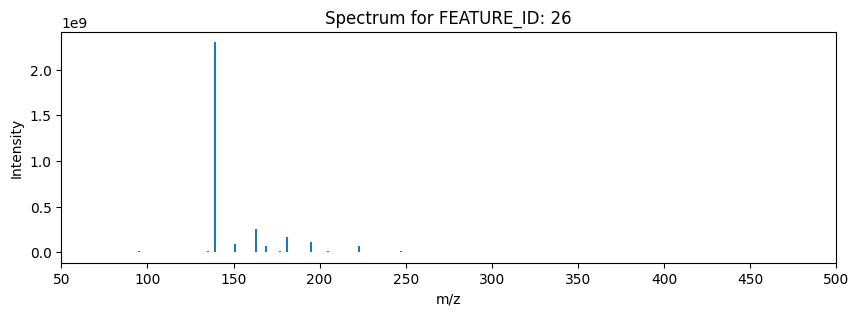

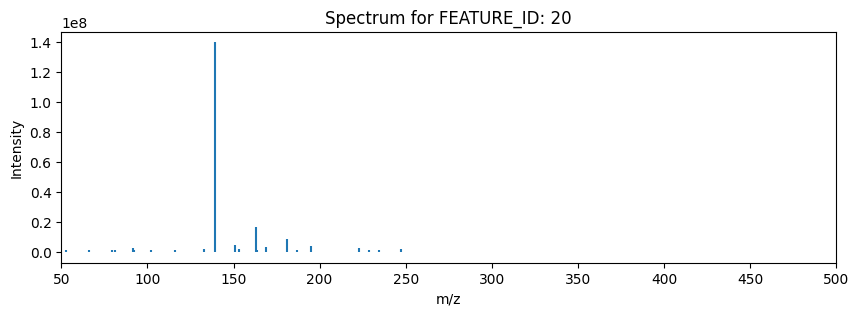

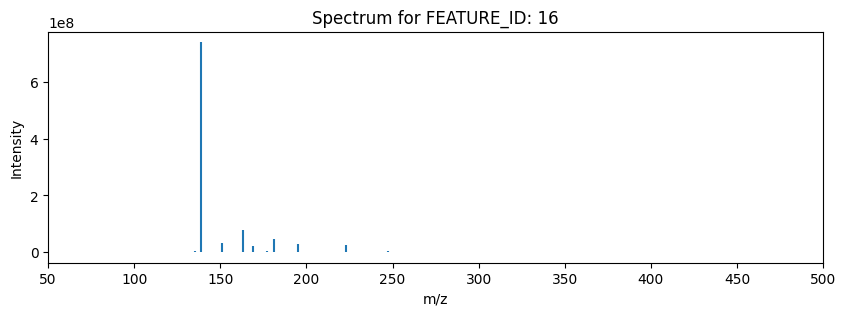

In [27]:

# List of MGF files and feature IDs
mgf_feature_pairs = [
    (r'C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_1_2024_10_02.mgf', ['25']),
    (r'C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_2_2024_10_02.mgf', ['26']),
    (r'C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_3_2024_10_08.mgf', ['20']),
    (r'C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\Controles_Lote_4_2024_10_08.mgf', ['16'])
]

# Loop over each file-feature pair and plot
for mgf_file, feature_ids in mgf_feature_pairs:
    plot_ms_spectra_direct_read(mgf_file, feature_ids, mz_min=50, mz_max=500)


In [28]:
import matplotlib.pyplot as plt
import itertools

def get_spectrum_by_feature_id(spectra, batch_name, feature_id):
    """
    Retorna um espectro com base no valor de FEATURE_ID dentro de um lote.
    Args:
        spectra (dict): Dicionário de espectros por lote.
        batch_name (str): Nome do lote.
        feature_id (str): Valor alvo de FEATURE_ID.
    Returns:
        dict: O espectro correspondente ou None se não for encontrado.
    """
    for spectrum in spectra[batch_name]:
        if 'FEATURE_ID' in spectrum['params']:
            if spectrum['params']['FEATURE_ID'] == feature_id:
                return spectrum
    return None

def plot_spectra_as_stem_with_colors(spectra, batch_feature_map, title="Overlaid Spectra Across Batches"):
    """
    Plots spectra as vertical bars (stem plot) with different colors for selected FEATURE_IDs across batches.

    Args:
        spectra (dict): Dictionary containing spectra by batch.
        batch_feature_map (dict): Mapping of {batch_name: FEATURE_ID}.
        title (str): Title of the plot.
    """
    plt.ion()  # Enable interactive mode
    plt.figure(figsize=(12, 4))
    colors = itertools.cycle(plt.cm.tab10.colors)  # Use a color cycle

    for batch_name, feature_id in batch_feature_map.items():
        if batch_name in spectra:
            spectrum = get_spectrum_by_feature_id(spectra, batch_name, feature_id)
            if spectrum:
                mz_array = spectrum['m/z array']
                intensity_array = spectrum['intensity array']
                color = next(colors)
                # Create stem plot
                markerline, stemlines, baseline = plt.stem(
                    mz_array, intensity_array, label=f"Batch: {batch_name}, FEATURE_ID: {feature_id}", basefmt=" "
                )
                plt.setp(stemlines, color=color, linestyle="-", linewidth=1)  # Set color for vertical lines
                plt.setp(markerline, color=color, marker="", markersize=5)   # Set color for markers
            else:
                print(f"FEATURE_ID {feature_id} not found in batch {batch_name}.")
        else:
            print(f"Batch {batch_name} not found in spectra.")

    plt.xlabel("m/z")
    plt.ylabel("Intensity")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


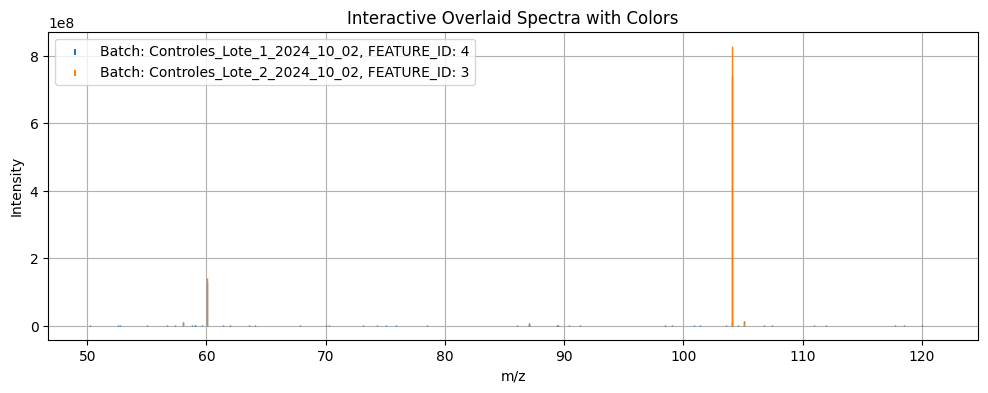

In [29]:
# Example: Choose FEATURE_IDs for different batches
batch_feature_map = {
    "Controles_Lote_1_2024_10_02": "4",  # FEATURE_ID for the first batch
    "Controles_Lote_2_2024_10_02": "3",  # FEATURE_ID for the second batch
    #"Controles_Lote_3_2024_10_08": "13",  # FEATURE_ID for the third batch
    #"Controles_Lote_4_2024_10_08": "13",  # FEATURE_ID for the fourth batch
    # Add more batches and FEATURE_IDs as needed
}

# Plot the spectra
plot_spectra_as_stem_with_colors(spectra, batch_feature_map, title="Interactive Overlaid Spectra with Colors")

---
#### Organize dataset


# PRECISA SER CONSERTADO

In [ ]:
MSfiltered_aligned_features_df.iloc[[29]]

In [30]:
# Initialize a dictionary to store the combined classification row
classification_row = {'feature_info': 'group'}

# Get all file paths ending with '_MetaboAnalyst.csv'
file_paths = [
    os.path.join(directory_path, f)
    for f in os.listdir(directory_path)
    if f.endswith('_MetaboAnalyst.csv')
]

# Loop through each file to process them
for file in file_paths:
    df = pd.read_csv(file)
    
    # Get the batch identifier from the filename
    filename = os.path.basename(file).replace('_MetaboAnalyst.csv', '')
    
    # Get the first row
    first_row = df.iloc[0].copy()
    
    # Append the batch identifier to each value in the first row
    for col in first_row.index:
        if col not in ['row ID', 'label']:  # Exclude non-sample columns
            classification_row[f"{filename}_{col}"] = first_row[col]

# Convert the combined row dictionary to a DataFrame with a single row
classification_combined = pd.DataFrame([classification_row])

# Replace NaN values with 0
classification_combined.fillna(0, inplace=True)

# Create the subdirectory if it doesn't exist
output_dir = os.path.join(directory_path, 'combined_results')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the modified DataFrame to the new subdirectory
output_file_path = os.path.join(output_dir, 'classification.csv')
classification_combined.to_csv(output_file_path, index=False)

print(f"Modified combined file saved at: {output_file_path}")

# Display the combined classification DataFrame
display(classification_combined)

Modified combined file saved at: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\combined_results\classification.csv


,feature_info,Controles_Lote_1_2024_10_02_Filename,Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,Controles_Lote_1_2024_10_02_BLANK_20231024224356.mzML,Controles_Lote_1_2024_10_02_BLANK_20231024172649.mzML,Controles_Lote_1_2024_10_02_BLANK.mzML,Controles_Lote_1_2024_10_02_MPCQExt_20231024174844.mzML,Controles_Lote_1_2024_10_02_MPCQExt_20231024230550.mzML,Controles_Lote_1_2024_10_02_MPCQExt_20231025023336.mzML,Controles_Lote_1_2024_10_02_CQExt.mzML,Controles_Lote_1_2024_10_02_MPCQExt.mzML,Controles_Lote_1_2024_10_02_CQExt_20231024150135.mzML,Controles_Lote_1_2024_10_02_CQExt_20231024173747.mzML,Controles_Lote_1_2024_10_02_CQExt_20231024225453.mzML,Controles_Lote_1_2024_10_02_CQExt_20231024202144.mzML,Controles_Lote_1_2024_10_02_CQExt_20231025022239.mzML,Controles_Lote_2_2024_10_02_Filename,Controles_Lote_2_2024_10_02_BLANK_20231027104459.mzML,Controles_Lote_2_2024_10_02_BLANK_20231027133206.mzML,Controles_Lote_2_2024_10_02_BLANK_20231027160510.mzML,Controles_Lote_2_2024_10_02_BLANK_20231025060121.mzML,Controles_Lote_2_2024_10_02_MPCQExt_20231025090714.mzML,Controles_Lote_2_2024_10_02_BLANK_20231025024434.mzML,Controles_Lote_2_2024_10_02_CQExt_20231027161607.mzML,Controles_Lote_2_2024_10_02_MPCQExt_20231025030633.mzML,Controles_Lote_2_2024_10_02_CQExt_20231027134303.mzML,Controles_Lote_2_2024_10_02_MPCQExt_20231025062315.mzML,Controles_Lote_2_2024_10_02_CQExt_20231027105901.mzML,Controles_Lote_2_2024_10_02_BLANK_20231025084520.mzML,Controles_Lote_2_2024_10_02_CQExt_20231025025536.mzML,Controles_Lote_2_2024_10_02_MPCQExt_20231027110958.mzML,Controles_Lote_2_2024_10_02_CQExt_20231025085618.mzML,Controles_Lote_2_2024_10_02_CQExt_20231025061218.mzML,Controles_Lote_3_2024_10_08_Filename,Controles_Lote_3_2024_10_08_BLANK_20231027212212.mzML,Controles_Lote_3_2024_10_08_BLANK_20231027184908.mzML,Controles_Lote_3_2024_10_08_BLANK_20231028021108.mzML,Controles_Lote_3_2024_10_08_CQExt_20231027190006.mzML,Controles_Lote_3_2024_10_08_CQExt_20231027213309.mzML,Controles_Lote_3_2024_10_08_CQExt_20231028022205.mzML,Controles_Lote_3_2024_10_08_MPCQExt_20231027162704.mzML,Controles_Lote_3_2024_10_08_MPCQExt_20231028023305.mzML,Controles_Lote_3_2024_10_08_MPCQExt_20231027214406.mzML,Controles_Lote_4_2024_10_08_Filename,Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML
0,group,group,Blank,Blank,Blank,Blank,Blank,Blank,MPQCExt,MPQCExt,MPQCExt,QCExt,MPQCExt,QCExt,QCExt,QCExt,QCExt,QCExt,group,Blank,Blank,Blank,Blank,MPQCExt,Blank,QCExt,MPQCExt,QCExt,MPQCExt,QCExt,Blank,QCExt,MPQCExt,QCExt,QCExt,group,Blank,Blank,Blank,QCExt,QCExt,QCExt,MPQCExt,MPQCExt,MPQCExt,group,Blank,Blank,Blank,QCExt,MPQCExt,MPQCExt,QCExt,QCExt,MPQCExt


In [31]:
# Identify the sample columns to keep
sample_columns = [col for col in MSfiltered_aligned_features_df.columns if col.endswith('.mzML') or col.endswith('.mzXML')]

# Create a new DataFrame with the concatenated 'scan_number', 'mz_value', 'rt_value' column and the sample columns
filtered_df = MSfiltered_aligned_features_df[sample_columns].copy()
filtered_df['feature_info'] = MSfiltered_aligned_features_df.apply(lambda row: f"{int(row['scan_number'])}_{row['mz_value']}_{row['rt_value']}", axis=1)

# Reorder columns to have 'feature_info' first
filtered_df = filtered_df[['feature_info'] + sample_columns]

# Replace all NaN values with zeros
filtered_df.fillna(0, inplace=True)

# Create the subdirectory if it doesn't exist
output_dir = os.path.join(directory_path, 'alignment_info_df')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the new DataFrame to a CSV file
output_file_path = os.path.join(output_dir, 'filtered_aligned_features.csv')
filtered_df.to_csv(output_file_path, index=False)

# Display the filtered DataFrame
pd.set_option("max_colwidth", None)
display(filtered_df.shape)

(55, 51)

In [33]:
# Identify the sample columns to keep
sample_columns = [col for col in MSfiltered_aligned_features_df.columns if col.endswith('.mzML') or col.endswith('.mzXML')]

# Create a new DataFrame with the concatenated 'scan_number', 'mz_value', 'rt_value' column and the sample columns
filtered_df = MSfiltered_aligned_features_df[sample_columns].copy()
filtered_df['feature_info'] = MSfiltered_aligned_features_df.apply(lambda row: f"{int(row['scan_number'])}_{row['mz_value']}_{row['rt_value']}", axis=1)

# Reorder columns to have 'feature_info' first
filtered_df = filtered_df[['feature_info'] + sample_columns]

# Replace all NaN values with zeros
filtered_df.fillna(0, inplace=True)

# Initialize a dictionary to store the combined classification row
classification_row = {'feature_info': 'group'}

# Loop through each file to process them
for file in file_paths:
    df = pd.read_csv(file)
    
    # Get the batch identifier from the filename
    filename = os.path.basename(file).replace('_MetaboAnalyst.csv', '')
    
    # Get the first row
    first_row = df.iloc[0].copy()
    
    # Append the batch identifier to each value in the first row
    for col in first_row.index:
        if col not in ['row ID', 'label']:  # Exclude non-sample columns
            classification_row[f"{filename}_{col}"] = first_row[col]

# Create a classification row based on the sample columns of filtered_df
classification_data = {'feature_info': 'group'}
for col in sample_columns:
    for key in classification_row.keys():
        if key in col:
            classification_data[col] = classification_row[key]

# Convert the combined classification dictionary to a DataFrame with a single row
classification_df = pd.DataFrame([classification_data])

# Replace NaN values with zeros
classification_df.fillna(0, inplace=True)

# Combine classification_df as the first row of filtered_df
final_df = pd.concat([classification_df, filtered_df], ignore_index=True)

# Create the subdirectory if it doesn't exist
output_dir = os.path.join(directory_path, 'combined_results')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the modified DataFrame to the new subdirectory
output_file_path = os.path.join(output_dir, 'filtered_aligned_features_with_classification.csv')
final_df.to_csv(output_file_path, index=False)

print(f"Modified combined file saved at: {output_file_path}")

# Display the final DataFrame
pd.set_option("max_colwidth", None)
#display(final_df)

Modified combined file saved at: C:\Users\borge\Documents\Batch_correction_from_MZmine\CQ_Batches\combined_results\filtered_aligned_features_with_classification.csv


In [34]:
# Reorganize column headers alphabetically
final_df = final_df[sorted(final_df.columns)]

# Display the first few rows to verify
final_df.head()

,df_Controles_Lote_1_2024_10_02_BLANK.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024145036.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024172649.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024201047.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231024224356.mzML,df_Controles_Lote_1_2024_10_02_BLANK_20231025021141.mzML,df_Controles_Lote_1_2024_10_02_CQExt.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024150135.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024173747.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024202144.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231024225453.mzML,df_Controles_Lote_1_2024_10_02_CQExt_20231025022239.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024174844.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231024230550.mzML,df_Controles_Lote_1_2024_10_02_MPCQExt_20231025023336.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025024434.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025060121.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231025084520.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027104459.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027133206.mzML,df_Controles_Lote_2_2024_10_02_BLANK_20231027160510.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025025536.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025061218.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231025085618.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027105901.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027134303.mzML,df_Controles_Lote_2_2024_10_02_CQExt_20231027161607.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025030633.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025062315.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231025090714.mzML,df_Controles_Lote_2_2024_10_02_MPCQExt_20231027110958.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231027184908.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231027212212.mzML,df_Controles_Lote_3_2024_10_08_BLANK_20231028021108.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231027190006.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231027213309.mzML,df_Controles_Lote_3_2024_10_08_CQExt_20231028022205.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027162704.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231027214406.mzML,df_Controles_Lote_3_2024_10_08_MPCQExt_20231028023305.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028024402.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028065531.mzML,df_Controles_Lote_4_2024_10_08_BLANK_20231028112847.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028025504.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028070628.mzML,df_Controles_Lote_4_2024_10_08_CQExt_20231028113944.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028030601.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028071725.mzML,df_Controles_Lote_4_2024_10_08_MPCQExt_20231028115041.mzML,feature_info
0,Blank,Blank,Blank,Blank,Blank,Blank,QCExt,QCExt,QCExt,QCExt,QCExt,QCExt,MPQCExt,MPQCExt,MPQCExt,MPQCExt,Blank,Blank,Blank,Blank,Blank,Blank,QCExt,QCExt,QCExt,QCExt,QCExt,QCExt,MPQCExt,MPQCExt,MPQCExt,MPQCExt,Blank,Blank,Blank,QCExt,QCExt,QCExt,MPQCExt,MPQCExt,MPQCExt,Blank,Blank,Blank,QCExt,QCExt,QCExt,MPQCExt,MPQCExt,MPQCExt,group
1,0.0,0.0,0.0,0.0,0.0,0.0,4101976.75,4373319.5,0,4063682.25,3973057.25,3804595.75,0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0,3654545.5,3463033.5,0,0,0,0,0,0.0,3663317.25,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,3_351.0694_0.22
2,0.0,0.0,0.0,0.0,0.0,0.0,1.3362971E7,1.3228956E7,0,1.3895894E7,1.3978304E7,1.2763402E7,1.0154984E7,7279942.5,1.0058472E7,8505989.0,0.0,0.0,8642331.0,0.0,0.0,0.0,1.3314572E7,1.4271618E7,1.2981169E7,7035975.0,6848943.5,6289661.0,9436894.0,9495382.0,0.0,1.3405593E7,0.0,0.0,0.0,6037501.0,6336416.0,5757712.0,1.1028738E7,1.0221159E7,1.136268E7,0.0,0.0,0.0,7522541.0,5071682.0,7068131.0,9592265.0,8801461.0,8794468.0,4_104.1071_0.23
3,0.0,0.0,0.0,0.0,0.0,0.0,1.5468547E7,1.4557759E7,1.5063253E7,1.5061479E7,1.4217054E7,1.4010193E7,9218374.0,5838549.0,8136458.5,5668001.0,0.0,0.0,5905934.0,0.0,0.0,0

In [ ]:
final_df.iloc[30]

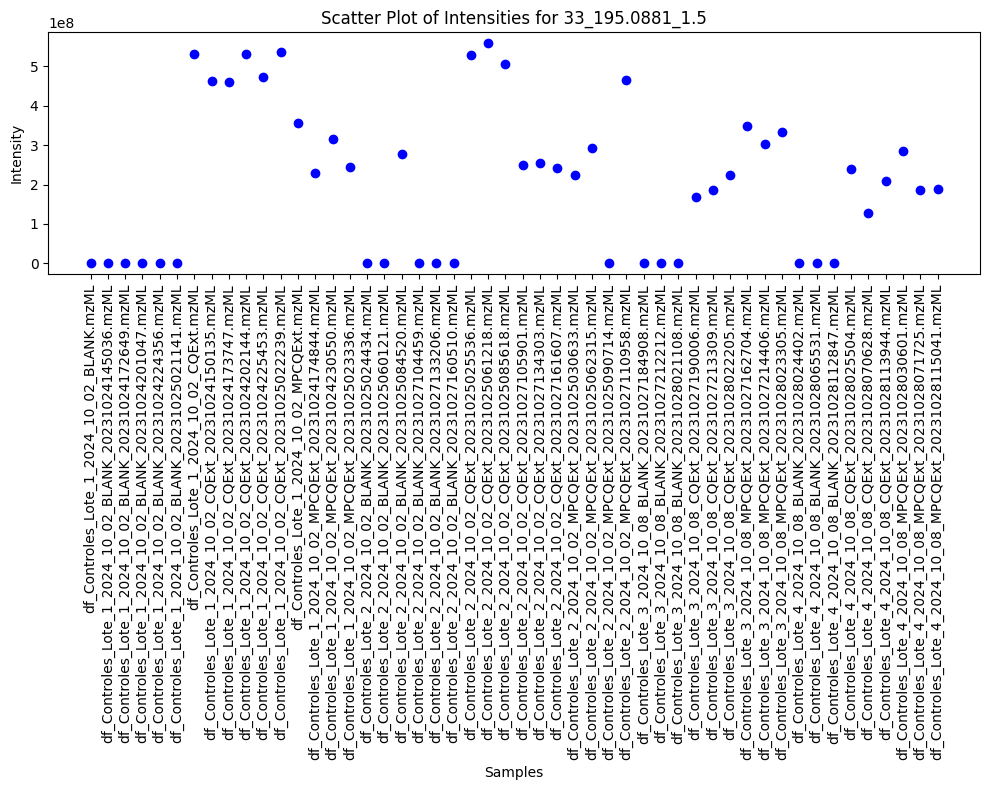

In [40]:
import matplotlib.pyplot as plt

# Select the row based on its 'feature_info' value or row index
selected_row = final_df[final_df['feature_info'] == '33_195.0881_1.5'].iloc[0]  # Replace 'group' with your desired feature_info

# Extract sample columns (those that contain intensities)
sample_columns = sorted([col for col in final_df.columns if col.endswith('.mzML') or col.endswith('.mzXML')])

# Extract the intensity values for the selected row
intensities = selected_row[sample_columns].values

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(sample_columns, intensities, color='blue')
plt.title(f'Scatter Plot of Intensities for {selected_row["feature_info"]}')
plt.xlabel('Samples')
plt.ylabel('Intensity')
plt.xticks(rotation=90)  # Rotate x labels for readability
plt.tight_layout()

# Show the plot
plt.show()


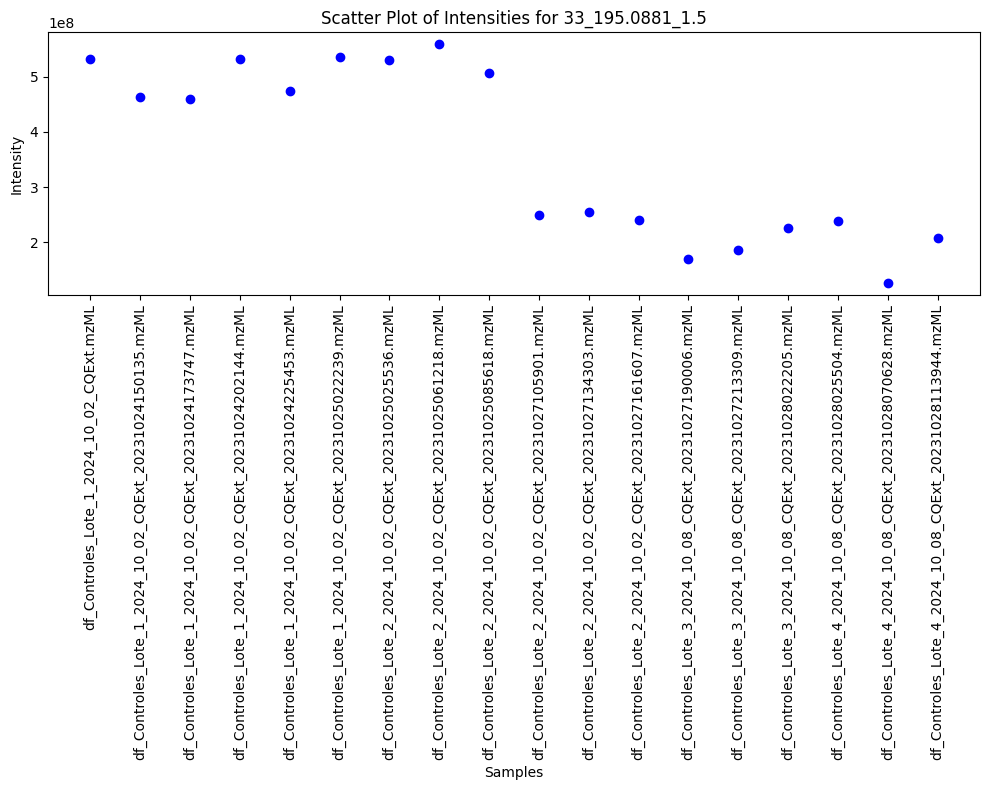

In [44]:
import matplotlib.pyplot as plt

# Select the row based on its 'feature_info' value or row index
selected_row = final_df[final_df['feature_info'] == '33_195.0881_1.5'].iloc[0]  # Replace 'group' with your desired feature_info

# Extract sample columns (those that contain intensities and have 'CQExt' in the column headers)
sample_columns = sorted([col for col in final_df.columns if ('_CQExt' in col) and (col.endswith('.mzML') or col.endswith('.mzXML'))])

# Extract the intensity values for the selected row
intensities = selected_row[sample_columns].values.astype(float)  # Ensure numeric type

# Create the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(sample_columns, intensities, color='blue')
plt.title(f'Scatter Plot of Intensities for {selected_row["feature_info"]}')
plt.xlabel('Samples')
plt.ylabel('Intensity')
plt.xticks(rotation=90)  # Rotate x labels for readability
plt.tight_layout()


# Show the plot
plt.show()
